In [1]:
pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('Display.max_columns', 100)
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'craig-shaffer-data-445-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'customers.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the datafile
customers = pd.read_csv(file_content_stream)
customers.head()

,ID,Visit_Time,Average_Expense,Sex,Age
0,1,3,5.7,0,10
1,2,5,14.5,0,27
2,3,16,33.5,0,32
3,4,5,15.9,0,30
4,5,16,24.9,0,23


In [3]:
# drop ID
customers=customers.drop(columns = 'ID', axis = 1)
customers.head()

,Visit_Time,Average_Expense,Sex,Age
0,3,5.7,0,10
1,5,14.5,0,27
2,16,33.5,0,32
3,5,15.9,0,30
4,16,24.9,0,23


In [4]:
#scale the data
scaler=MinMaxScaler()
customers[['Visit_Time_0_1', 'Average_Expense_0_1','Sex_0_1','Age_0_1']] = scaler.fit_transform(customers)
customers.head(10)

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1
0,3,5.7,0,10,0.117647,0.041096,0.0,0.051282
1,5,14.5,0,27,0.235294,0.342466,0.0,0.487179
2,16,33.5,0,32,0.882353,0.993151,0.0,0.615385
3,5,15.9,0,30,0.235294,0.390411,0.0,0.564103
4,16,24.9,0,23,0.882353,0.698630,0.0,0.384615
5,3,12.0,0,15,0.117647,0.256849,0.0,0.179487
6,12,28.5,0,33,0.647059,0.821918,0.0,0.641026
7,14,18.8,0,27,0.764706,0.489726,0.0,0.487179
8,6,23.8,0,16,0.294118,0.660959,0.0,0.205128
9,3,5.3,0,11,0.117647,0.027397,0.0,0.076923


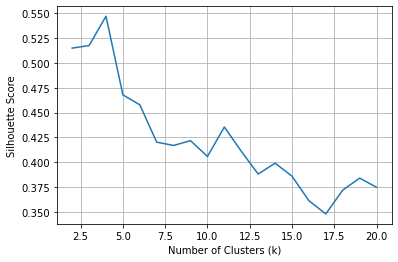

In [5]:
#define a list to hold silhouette scores
silhouette = list()
for i in range (2,21):
    
    #clustering the data into i clusters
    kmeans_md = KMeans(n_clusters = i, n_init=20).fit(customers[['Visit_Time_0_1', 'Average_Expense_0_1','Sex_0_1','Age_0_1']])
    kmeans_md_lables = kmeans_md.labels_
    
    #computing silhouette score
    score = silhouette_score(customers[['Visit_Time_0_1', 'Average_Expense_0_1','Sex_0_1','Age_0_1']],kmeans_md_lables)
    silhouette.append(score)
    
#visualizing results
import matplotlib.pyplot as plt

plt.plot(range(2,21),silhouette)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show();

In [6]:
x = customers[['Visit_Time_0_1', 'Average_Expense_0_1','Sex_0_1','Age_0_1']]

#running fuzzy c means for 4 clusters
fc,W,u0,d,jm,p,pc=cmeans(x.T,c=4,m=1.25,error=1e-6,maxiter=1000)

In [7]:
#likelihoods of cluster 0
W[0]

array([8.05936649e-05, 1.58707467e-05, 4.84672855e-06, 1.22199692e-04,
       1.53503037e-08, 5.43733649e-08, 1.11264117e-06, 2.17056354e-06,
       2.33130354e-04, 7.53680392e-05, 1.04710710e-06, 1.18727321e-07,
       1.11264117e-06, 6.70547581e-07, 1.84588374e-05, 5.26241860e-05,
       2.68178200e-08, 4.24029805e-06, 3.12114236e-06, 4.53514443e-03,
       9.99999782e-01, 4.08164962e-03, 9.99977997e-01, 1.85328068e-03,
       4.60048433e-06, 9.99962545e-01, 9.99999631e-01, 5.58893690e-05,
       9.99999999e-01, 9.99542678e-01, 9.98686632e-01, 1.52535984e-07,
       5.85797892e-07, 2.85889395e-04, 9.99542678e-01, 9.99999714e-01,
       1.33365051e-04, 9.99888938e-01, 9.99999932e-01, 9.99999782e-01,
       9.99968832e-01, 9.99707184e-01, 9.99996391e-01, 9.60636937e-01,
       1.92258954e-05, 5.58893690e-05, 7.68046619e-01, 9.99989541e-01,
       9.98683096e-01, 1.85328068e-03, 9.99965612e-01, 1.11810244e-02,
       1.46871599e-04, 9.99196967e-01, 6.14148077e-01, 9.99995467e-01,
      

In [8]:
#creating cluster column
customers['cluster']=np.nan

#changing likelihood to labels
customers['cluster']= np.where(W[0]>0.7,1,customers['cluster'])
customers['cluster']= np.where(W[1]>0.7,2,customers['cluster'])
customers['cluster']= np.where(W[2]>0.7,3,customers['cluster'])
customers['cluster']= np.where(W[3]>0.7,4,customers['cluster'])

In [9]:
#cluster 1
cluster_1 = customers[customers['cluster']==1].reset_index(drop=True)
cluster_1.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,24.000000,24.000000,24.0,24.000000,24.000000,24.000000,24.0,24.000000,24.0
mean,5.416667,10.591667,1.0,15.291667,0.259804,0.208619,1.0,0.186966,1.0
std,2.430185,4.474752,0.0,4.666990,0.142952,0.153245,0.0,0.119666,0.0
min,1.000000,4.500000,1.0,8.000000,0.000000,0.000000,1.0,0.000000,1.0
25%,3.000000,7.875000,1.0,11.750000,0.117647,0.115582,1.0,0.096154,1.0
50%,6.000000,10.900000,1.0,16.000000,0.294118,0.219178,1.0,0.205128,1.0
75%,7.000000,12.000000,1.0,17.500000,0.352941,0.256849,1.0,0.243590,1.0
max,10.000000,23.800000,1.0,23.000000,0.529412,0.660959,1.0,0.384615,1.0


In [10]:
#cluster 2
cluster_2 = customers[customers['cluster']==2].reset_index(drop=True)
cluster_2.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,11.000000,11.000000,11.0,11.00000,11.000000,11.000000,11.0,11.000000,11.0
mean,4.909091,12.709091,0.0,17.00000,0.229947,0.281133,0.0,0.230769,2.0
std,1.700267,6.060108,0.0,6.78233,0.100016,0.207538,0.0,0.173906,0.0
min,3.000000,4.600000,0.0,9.00000,0.117647,0.003425,0.0,0.025641,2.0
25%,3.500000,7.150000,0.0,12.00000,0.147059,0.090753,0.0,0.102564,2.0
50%,5.000000,14.500000,0.0,16.00000,0.235294,0.342466,0.0,0.205128,2.0
75%,6.000000,16.000000,0.0,20.00000,0.294118,0.393836,0.0,0.307692,2.0
max,8.000000,23.800000,0.0,30.00000,0.411765,0.660959,0.0,0.564103,2.0


In [11]:
#cluster 3
cluster_3 = customers[customers['cluster']==3].reset_index(drop=True)
cluster_3.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,8.000000,8.000000,8.0,8.000000,8.000000,8.000000,8.0,8.000000,8.0
mean,14.375000,25.587500,0.0,26.625000,0.786765,0.722175,0.0,0.477564,3.0
std,1.846812,4.647714,0.0,5.629958,0.108636,0.159168,0.0,0.144358,0.0
min,12.000000,18.800000,0.0,18.000000,0.647059,0.489726,0.0,0.256410,3.0
25%,13.500000,22.950000,0.0,22.750000,0.735294,0.631849,0.0,0.378205,3.0
50%,14.000000,25.400000,0.0,26.000000,0.764706,0.715753,0.0,0.461538,3.0
75%,16.000000,28.500000,0.0,32.250000,0.882353,0.821918,0.0,0.621795,3.0
max,17.000000,33.500000,0.0,33.000000,0.941176,0.993151,0.0,0.641026,3.0


In [12]:
#cluster 4
cluster_4 = customers[customers['cluster']==4].reset_index(drop=True)
cluster_4.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,16.000000,16.000000,16.0,16.000000,16.000000,16.000000,16.0,16.000000,16.0
mean,12.250000,25.362500,1.0,31.187500,0.661765,0.714469,1.0,0.594551,4.0
std,2.955221,4.336339,0.0,8.336416,0.173837,0.148505,0.0,0.213754,0.0
min,8.000000,17.800000,1.0,17.000000,0.411765,0.455479,1.0,0.230769,4.0
25%,10.000000,21.100000,1.0,26.000000,0.529412,0.568493,1.0,0.461538,4.0
50%,12.000000,25.450000,1.0,28.500000,0.647059,0.717466,1.0,0.525641,4.0
75%,13.250000,28.275000,1.0,36.750000,0.720588,0.814212,1.0,0.737179,4.0
max,18.000000,33.700000,1.0,47.000000,1.000000,1.000000,1.0,1.000000,4.0


Cluster 1 = young men, short visit time, spend less money

Cluster 2 = young women, short visit time, spend less money

Cluster 3 = old women, long visit time, spend more money

Cluster 4 = old men, long visit time, spend more money
